# MAST30034_Applied Data Science_Project1

## Import Libraries

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from geodatasets import get_path
import pandas as pd
import geopandas as gpd
from pyspark.sql.functions import date_format, hour, dayofweek
import seaborn as sns
from scipy.stats import chi2_contingency
from pyspark.sql.functions import count as spark_count
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pyarrow as pa
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# Create a spark session
spark = (
SparkSession.builder.appName("ADS project 1")
.config("spark.sql.repl.eagerEval.enabled", True)
.config("spark.driver.memory","6G")
.config("spark.executor.memory","6G")
.config("spark.sql.parquet.cacheMetadata", "true")
.getOrCreate()
)

## Read the data

In [8]:
taxi_data_9 = spark.read.parquet('../data/after_EDA_data_Engineering/taxi-9').toPandas()
citybike_data_9 = spark.read.parquet('../data/after_EDA_data_Engineering/citybike-9').toPandas()
taxi_data_2 = spark.read.parquet('../data/after_EDA_data_Engineering/taxi-2').toPandas()
citybike_data_2 = spark.read.parquet('../data/after_EDA_data_Engineering/citybike-2').toPandas()

In [9]:
taxi_data_9['taxi_count'].describe()

count     6551.000000
mean      4112.095863
std       2373.423478
min          2.000000
25%       1712.500000
50%       4733.000000
75%       5924.000000
max      10499.000000
Name: taxi_count, dtype: float64

## One hot encoding

In [10]:
def one_hot_encode(train_df, test_df, columns_to_encode):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    train_encoded = encoder.fit_transform(train_df[columns_to_encode])
    train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(columns_to_encode))
    train_df = pd.concat([train_df.drop(columns_to_encode, axis=1), train_encoded_df], axis=1)
    test_encoded = encoder.transform(test_df[columns_to_encode])
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(columns_to_encode))
    test_df = pd.concat([test_df.drop(columns_to_encode, axis=1), test_encoded_df], axis=1)
    
    return train_df, test_df

In [11]:
# the function use to do the log transform
def log_transform(train_df, test_df, columns_to_transform):
    train_df[columns_to_transform] = train_df[columns_to_transform].astype(float)
    test_df[columns_to_transform] = test_df[columns_to_transform].astype(float)
    for column in columns_to_transform:
        train_df[column] = np.log1p(train_df[column])
        test_df[column] = np.log1p(test_df[column])
    
    return train_df, test_df

In [12]:
# The function use to do the min-max scale
def normalize_data(train_df, test_df, columns_to_normalize):
    scaler = MinMaxScaler()
    train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
    test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])
    return train_df, test_df

In [13]:
taxi_data_9, taxi_data_2 = one_hot_encode(taxi_data_9, taxi_data_2, ['hour','preciptype','icon','day_of_week'])
taxi_data_9, taxi_data_2 = log_transform(taxi_data_9, taxi_data_2,['windgust','visibility','solarenergy','taxi_count'])
taxi_data_9, taxi_data_2 = normalize_data(taxi_data_9, taxi_data_2,['temp', 'humidity', 'windgust', 'visibility', 'solarenergy'])

In [14]:
citybike_data_9, citybike_data_2 = one_hot_encode(citybike_data_9, citybike_data_2, ['hour','uvindex'])
citybike_data_9, citybike_data_2 = log_transform(citybike_data_9, citybike_data_2,['windgust','visibility','solarenergy','severerisk','citybike_count'])
citybike_data_9, citybike_data_2 = normalize_data(citybike_data_9, citybike_data_2,['temp', 'humidity', 'windgust', 'visibility', 'solarenergy','severerisk','dew','cloudcover'])

In [15]:
taxi_data_9.shape

(6551, 49)

In [16]:
taxi_data_2.shape

(1489, 49)

In [17]:
citybike_data_9.shape

(6551, 44)

In [18]:
citybike_data_2.shape

(1489, 44)

## Linear regression model

In [19]:
# The function use to do the linear regression
def linear_regression_with_cv(train_df_pd, test_df_pd, goal):
    train_df = spark.createDataFrame(train_df_pd)
    test_df = spark.createDataFrame(test_df_pd)
    features_columns = [col for col in train_df.columns if col != goal]
    assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)
    lr = LinearRegression(featuresCol="features", labelCol=goal)
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
        .build()
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=goal, metricName="rmse")
    crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=5)
    cvModel = crossval.fit(train_df)
    test_predictions = cvModel.transform(test_df)
    rmse = evaluator.evaluate(test_predictions)
    r2 = RegressionEvaluator(predictionCol="prediction", labelCol=goal, metricName="r2").evaluate(test_predictions)
    
    print(f"Test Data RMSE: {rmse}")
    print(f"Test Data R2: {r2}")
    test_predictions_pd = test_predictions.select("prediction", goal).toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(test_predictions_pd[goal], test_predictions_pd["prediction"], color='blue', alpha=0.5, label='Data points')
    
    m, b = np.polyfit(test_predictions_pd[goal], test_predictions_pd["prediction"], 1)
    plt.plot(test_predictions_pd[goal], m * test_predictions_pd[goal] + b, color='red', linewidth=2, label='Best fit line')
    
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Linear Regression - Actual vs Predicted")
    plt.legend()
    plt.show()


24/08/24 19:02:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/08/24 19:02:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/24 19:02:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Test Data RMSE: 0.45186923735461537
Test Data R2: 0.8036641807743918


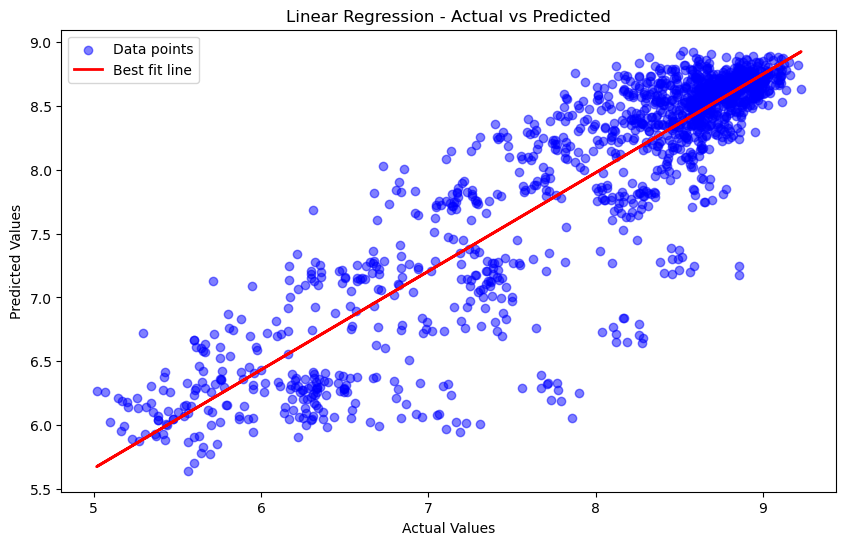

In [20]:
linear_regression_with_cv(taxi_data_9, taxi_data_2, 'taxi_count')

Test Data RMSE: 0.49444264187157494
Test Data R2: 0.8187554162019622


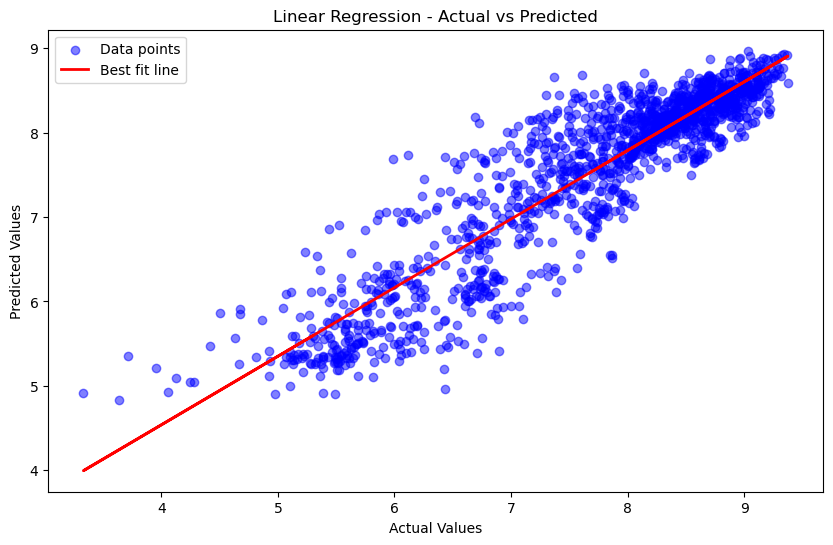

In [21]:
linear_regression_with_cv(citybike_data_9, citybike_data_2, 'citybike_count')

## Random forest model

In [22]:
def randomForestRegressor(train_data, val_data, goal, depth_range=range(1, 21)):
    X_train = train_data.drop(columns=[goal])
    y_train = train_data[goal]
    X_val = val_data.drop(columns=[goal])
    y_val = val_data[goal]
    
    results = {'depth': [], 'train_score': [], 'test_score': []}
    for depth in depth_range:
        rf = RandomForestRegressor(max_depth=depth, max_features='sqrt',
                                   bootstrap=False, random_state=42, n_estimators=100)
        cv_results = cross_validate(rf, X_train, y_train, cv=5, return_train_score=True, scoring='r2')
        train_mean = cv_results['train_score'].mean()
        test_mean = cv_results['test_score'].mean()
        results['depth'].append(depth)
        results['train_score'].append(train_mean)
        results['test_score'].append(test_mean)
    
    results_df = pd.DataFrame(results)
    max_test_score_row = results_df.loc[results_df['test_score'].idxmax()]
    best_depth = int(max_test_score_row['depth']) 

    best_rf = RandomForestRegressor(max_depth=best_depth, max_features='sqrt',
                                    bootstrap=False, random_state=42, n_estimators=100)
    best_rf.fit(X_train, y_train)
    y_val_pred = best_rf.predict(X_val)
    r2_score_val = r2_score(y_val, y_val_pred)
    print(f'Validation R² with best depth={best_depth}: {r2_score_val}')
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['depth'], results_df['train_score'], label='Training R²', marker='o', color='blue')
    plt.plot(results_df['depth'], results_df['test_score'], label='Testing R²', marker='s', linestyle='--', color='red')
    plt.xlabel('Depth')
    plt.ylabel('R²')
    plt.title('Random Forest R² vs. Depth')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_depth, r2_score_val

Validation R² with best depth=20: 0.8495124100467355
Root Mean Squared Error (RMSE): 0.3956064376897052


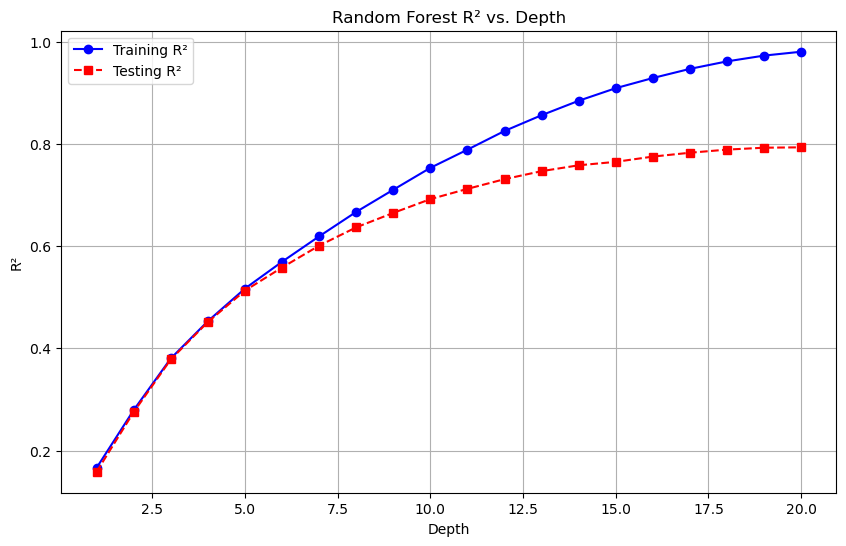

(20, 0.8495124100467355)

In [23]:
randomForestRegressor(taxi_data_9, taxi_data_2, 'taxi_count')

Validation R² with best depth=20: 0.7767583176290894
Root Mean Squared Error (RMSE): 0.5487455899336722


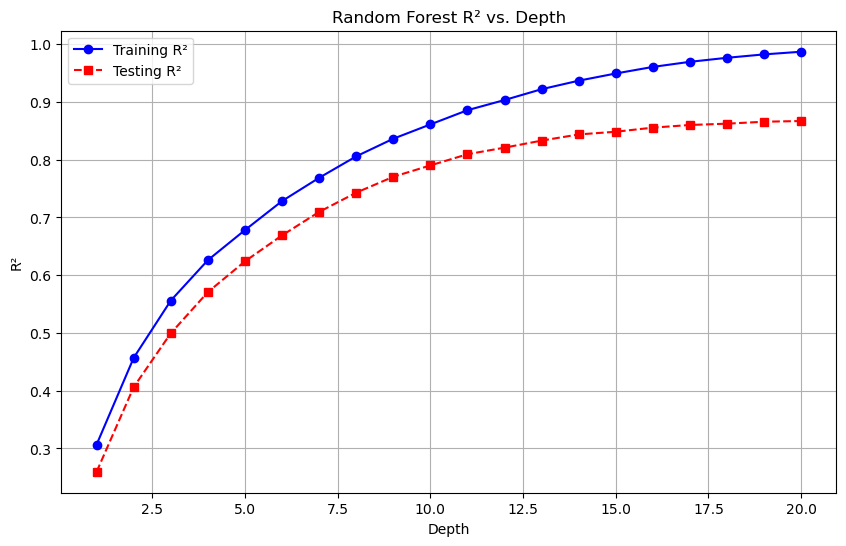

(20, 0.7767583176290894)

In [24]:
randomForestRegressor(citybike_data_9, citybike_data_2, 'citybike_count')